In [1]:
%reload_ext autoreload
%autoreload 2
#%reload_ext notexbook
#%texify

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/')
import cellbgnet
import cellbgnet.utils

from cellbgnet.datasets import DataSimulator
from cellbgnet.utils.hardware import cpu, gpu
from cellbgnet.model import CellBGModel
from cellbgnet.simulation.psf_kernel import SMAPSplineCoefficient
from cellbgnet.generic.emitter import EmitterSet
from cellbgnet.train_loss_infer import generate_probmap_cells

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/notebooks')

from skimage.io import imread
from skimage.measure import label
import random
import edt
from skimage.filters import gaussian
from scipy.ndimage import rotate
import random
import pickle
import pathlib
from pathlib import Path
%matplotlib qt5

In [4]:
train_size = 128
margin_empty = 0.05
batch_size = 10
z_prior=[-1, 1]
min_ph = 0.428

In [5]:
prob_map = np.zeros([1, train_size, train_size])
prob_map[0, int(margin_empty * train_size): int((1 - margin_empty) * train_size),
         int(margin_empty * train_size): int((1 - margin_empty) * train_size)] += 1
prob_map = prob_map / prob_map.sum() * 4

In [6]:
prob_map_t = torch.tensor(prob_map)

In [7]:
prob_map_t = prob_map_t.reshape(1, 1, prob_map_t.shape[-2], prob_map_t.shape[-1]).repeat_interleave(batch_size, 0)

In [8]:
prob_map_t.shape

torch.Size([10, 1, 128, 128])

In [9]:
locs = torch.distributions.Binomial(1, prob_map_t).sample()
zeros = torch.zeros_like(locs)
z = torch.distributions.Uniform(zeros + z_prior[0], zeros + z_prior[1]).sample()
x_os = torch.distributions.Uniform(zeros - 0.5, zeros + 0.5).sample()
y_os = torch.distributions.Uniform(zeros - 0.5, zeros + 0.5).sample()
ints = torch.distributions.Uniform(torch.zeros_like(locs) + min_ph,
                                   torch.ones_like(locs)).sample()
x_os *= locs
y_os *= locs
z *= locs
ints *= locs

In [10]:
locs.shape

torch.Size([10, 1, 128, 128])

In [11]:
x_os.shape, y_os.shape, z.shape, ints.shape

(torch.Size([10, 1, 128, 128]),
 torch.Size([10, 1, 128, 128]),
 torch.Size([10, 1, 128, 128]),
 torch.Size([10, 1, 128, 128]))

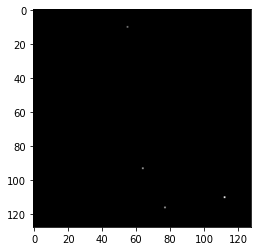

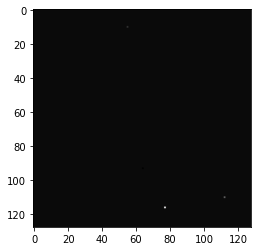

In [12]:
plt.figure()
plt.imshow(ints[0][0].numpy(), cmap='gray')
plt.show()
plt.figure()
plt.imshow(x_os[0][0].numpy(), cmap='gray')
plt.show()

In [13]:
batch_size, n_inp, h, w = locs.shape[0], locs.shape[1], locs.shape[2], locs.shape[3]
xyzi = torch.cat([x_os.reshape([-1, 1, h, w]), y_os.reshape([-1, 1, h, w]), 
                 z.reshape([-1, 1, h, w]), ints.reshape([-1, 1, h, w])], 1)

In [14]:
xyzi.shape

torch.Size([10, 4, 128, 128])

In [15]:
S = locs.reshape([-1, h, w])

In [16]:
S.shape, xyzi.shape

(torch.Size([10, 128, 128]), torch.Size([10, 4, 128, 128]))

In [17]:
n_samples = S.shape[0] // xyzi.shape[0] # for our case it will be one, as we don't use blinking
XYZI_rep = xyzi.repeat_interleave(n_samples, 0)

In [18]:
XYZI_rep.shape, S.shape

(torch.Size([10, 4, 128, 128]), torch.Size([10, 128, 128]))

In [19]:
s_inds = tuple(S.nonzero().transpose(1, 0))
x_os_vals = (XYZI_rep[:, 0][s_inds])[:, None, None]
y_os_vals = (XYZI_rep[:, 1][s_inds])[:, None, None]
# z_vals will be between -1 and 1, so they will be scaled to nm's here
z_vals = (XYZI_rep[:, 2][s_inds])[:, None, None]
#z_vals = 400 *(XYZI_rep[:, 2][s_inds])[:, None, None]
i_vals = (XYZI_rep[:, 3][s_inds])[:, None, None]

In [20]:
x_os_vals.shape, y_os_vals.shape, z_vals.shape

(torch.Size([37, 1, 1]), torch.Size([37, 1, 1]), torch.Size([37, 1, 1]))

In [80]:
n_emitters = len(s_inds[0])

In [133]:
xyz = torch.zeros((n_emitters, 3))
xyz[:, 0] = s_inds[1] - x_os_vals[:, 0, 0]
xyz[:, 1] = s_inds[2] - y_os_vals[:, 0, 0]
xyz[:, 2] = -500#z_vals[:, 0, 0]*500
photon_counts = 7000 * i_vals[:, 0, 0]
#photon_counts=torch.ones((n_emitters,))
frame_ix = s_inds[0]


In [134]:
photon_counts

tensor([3123.8689, 4185.9419, 6387.7220, 4188.1872, 3449.5595, 3838.5068,
        3879.1328, 3857.8161, 3686.1916, 4678.8131, 4256.7910, 5107.2064,
        4886.6535, 4139.1210, 5912.8864, 6022.7872, 3846.5109, 4712.4430,
        5987.8612, 6768.4554, 6231.9332, 6283.5469, 6445.8466, 6837.6724,
        4052.4923, 4376.7914, 5639.4687, 4679.6779, 4993.1908, 4803.4737,
        6884.4030, 4751.7370, 5886.1281, 6188.4066, 3364.6081, 5929.5944,
        6457.0954], dtype=torch.float64)

In [135]:
em = EmitterSet(xyz=xyz, phot=photon_counts, frame_ix=frame_ix.long(),
                id=torch.arange(n_emitters).long(), xy_unit='px', px_size=[-65, 65])

In [136]:
print(em)

EmitterSet
::num emitters: 37
::xy unit: px
::px size: tensor([-65.,  65.])
::frame range: 0 - 9
::spanned volume: [   7.549572   15.726474 -500.      ] - [ 119.8495   120.26703 -500.     ]


In [137]:
param_file = '../cellbgnet/utils/reference_files/reference_Axel.yaml'
param = cellbgnet.utils.param_io.ParamHandling().load_params(param_file)

psf_params = param.PSF.to_dict()
simulation_params = param.Simulation.to_dict()
hardware_params = param.Hardware.to_dict()
train_size = simulation_params['train_size']
calib_file = psf_params['calib_file']

In [138]:
psf = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
                xextent=[-0.5, 127.5],
                yextent=[-0.5, 127.5],
                img_shape=[128, 128],
                device='cuda',
                roi_size=None, roi_auto_center=None)

INITIATING CUDA IMPLEMENTATION


In [139]:
images = psf.forward(em.xyz_px, em.phot, em.frame_ix, ix_low=0, ix_high=batch_size-1)

In [140]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(images[0].numpy())
ax[1].imshow(S[0].numpy())
plt.show()

In [30]:
xyzi_out = torch.cat([x_os[:, :, None], y_os[:, :, None], z[:, :, None], ints[:, :, None]], 2)

In [31]:
x_os.shape

torch.Size([10, 1, 128, 128])

In [110]:
print(xyz[4:7, 2])
print(photon_counts[4:7])


tensor([419.9944, 288.6327, 219.9361])
tensor([3449.5595, 3838.5068, 3879.1328], dtype=torch.float64)


In [112]:
xyz[:, 2]

tensor([-330.7420,   73.0032, -226.5336,    9.2997,  419.9944,  288.6327,
         219.9361,  -55.8457, -280.4829,  354.1179,  -49.1153,   42.3140,
        -131.0833, -304.3746,  135.7513,  371.9028,  119.2344, -297.3761,
          55.5406,  291.0450,  367.6997,   60.9403,  -48.1121, -444.0425,
        -476.3845,   15.6784, -246.9846, -411.1091,  371.2677,  441.8641,
          47.9519,  468.3302,  -50.2303, -237.0907,  430.4861, -154.2435,
         275.0820])

In [32]:
xyzi_out.shape

torch.Size([10, 1, 4, 128, 128])

In [53]:
xyzi = xyzi_out[:, 0]

In [34]:
locs.shape

torch.Size([10, 1, 128, 128])

In [35]:
S = locs[:, 0]

In [36]:
s_inds = tuple(S.nonzero().transpose(1, 0))
# get these molecules' sub-pixel xy offsets, z positions and photons
xyzi_true = xyzi[s_inds[0], :, s_inds[1], s_inds[2]]

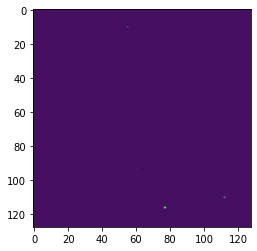

In [37]:
plt.figure()
plt.imshow(x_os[0, 0,].numpy())

In [38]:
s_inds[0], s_inds[1], s_inds[2]

(tensor([0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5,
         6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9]),
 tensor([ 10,  93, 110, 116,   8,  61, 114,  74, 110,  20,  22,  32, 104, 117,
         120,  10,  28,  32,  71,  13,  77,  82, 111, 114,  43,  26,  65,  82,
          10,  12,  15,  29,  74, 101,  60,  70,  82]),
 tensor([ 55,  64, 112,  77,  61,  55,  71,  19,  19, 119,  27, 105,  94, 120,
         117,  35,  72,  53,  61,  27,  98,  48,  48,  29,  16,  34,  29,  77,
         111,  51,  19,  86,  40,  67,  57, 114,  82]))

In [39]:

s_counts = torch.unique_consecutive(s_inds[0], return_counts=True)[1]
s_max = s_counts.max()

In [40]:
s_max

tensor(6)

In [41]:
s_counts

tensor([4, 3, 2, 6, 4, 5, 1, 3, 6, 3])